# Generating dataset 
This notebook shows how to generate the train and test set for the multimnist and multimnist_cluttered tasks

In [1]:
%matplotlib inline 
import matplotlib.pyplot as plt

import torch
import torchvision.transforms as T
from torchvision import datasets
import copy
import os
from tqdm.notebook import tqdm
import numpy as np 
np.set_printoptions(suppress=True)

import random

# Mnist for reconstruction (BLUR)
In this task, the model has to reconstruct blur version, given original clear mnist
- original mnist training dataset: 60k, 10k for testing

In [2]:
def get_tensorized_dataset(im_set):
    images = []
    labels = []
    for img, label in im_set:
        img = np.array(img)
        images.append(img)    
        labels.append(label)
        
    # convert to tensor and one-hot vector
    transform_tohot = T.Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
    images_tensorized = torch.stack([T.ToTensor()(im) for im in images])
    labels_tensorized = torch.stack([transform_tohot(label) for label in labels])
    
    return images_tensorized, labels_tensorized

def plot(imgs, num_rows = 1, with_orig=False, row_title=None, **imshow_kwargs):
#     if not isinstance(imgs, list):
#         raise ValueError('input images should be list form')

    num_cols = int(len(imgs)/num_rows) + (len(imgs)%num_rows > 0)
    fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
#     import pdb; pdb.set_trace()
    for row_idx in range(num_rows):
        for col_idx, img in enumerate(imgs[row_idx*num_cols:(row_idx+1)*num_cols]):
            ax = axs[row_idx, col_idx]
            ax.imshow(np.asarray(img), cmap='gray_r', vmin=0, vmax=1,  **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

#     if with_orig:
#         axs[0, 0].set(title='Original image')
#         axs[0, 0].title.set_size(8)
    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])
    plt.show()
#     plt.tight_layout()

# load original mnist
path_save = '../data/MNIST_recon'
dataset_type = 'test'


if dataset_type == 'train':
    im_set = datasets.MNIST('../data/',train=True, download=False)
elif dataset_type == 'test':
    im_set = datasets.MNIST('../data/',train=False, download=False)

orig_images_tensorized, orig_labels_tensorized = get_tensorized_dataset(im_set)
print(orig_images_tensorized.size())
print(orig_labels_tensorized.size())

torch.Size([10000, 1, 28, 28])
torch.Size([10000, 10])


In [3]:
# blurred version
kernelsize = 5
sigma =1.0
transforms = T.Compose([ T.GaussianBlur(kernelsize, sigma=sigma), T.ToTensor()])

if dataset_type == 'train':
    im_set = datasets.MNIST('../data/',train=True, download=False, transform=transforms,
                        target_transform=T.Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1)))
elif dataset_type == 'test':
    im_set = datasets.MNIST('../data/',train=False, download=False, transform=transforms,
                        target_transform=T.Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1)))

    
images = []
# labels = []
for img, label in im_set:
    images.append(img)    
#     labels.append(label)
        
blur_images_tensorized = torch.stack([im for im in images])
# blur_labels_tensorized = torch.stack([label for label in labels])
print(blur_images_tensorized.size())

bool_images_tensorized = (blur_images_tensorized >0.1).type(torch.float32)
# blur_labels_tensorized = torch.stack([label for label in labels])
print(bool_images_tensorized.size())

torch.Size([60000, 1, 28, 28])
torch.Size([60000, 1, 28, 28])


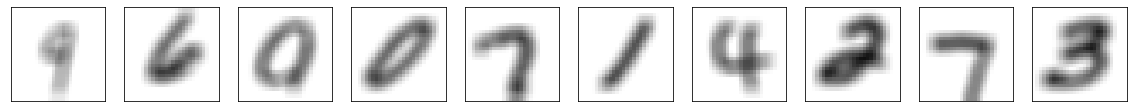

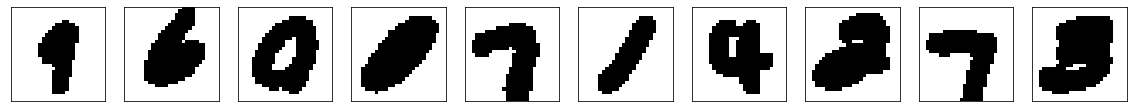

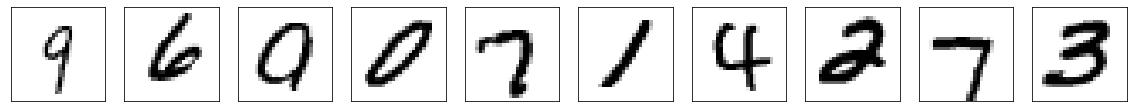

[tensor(9), tensor(6), tensor(9), tensor(0), tensor(7), tensor(1), tensor(4), tensor(2), tensor(7), tensor(3)]


In [4]:
# visualize erased images
plt.rcParams["figure.figsize"] = (20,3)
i =90#152
plottedimgs = [torch.movedim(blur_images_tensorized[i], 0 ,-1) for i in range(10*i,10*(i+1))]
plot(plottedimgs, num_rows=1)
plottedimgs = [torch.movedim(bool_images_tensorized[i], 0 ,-1) for i in range(10*i,10*(i+1))]
plot(plottedimgs, num_rows=1)
plottedimgs = [torch.movedim(orig_images_tensorized[i], 0 ,-1) for i in range(10*i,10*(i+1))]
plot(plottedimgs, num_rows=1)
print([l.argmax() for l in orig_labels_tensorized[10*i:10*(i+1)]])

In [5]:
# save tensors 
filename = os.path.join(path_save, f'{dataset_type}_blur_k{kernelsize}s{int(sigma)}.pt')
torch.save((orig_images_tensorized, blur_images_tensorized, orig_labels_tensorized), filename)
print(f'{filename} saved to disk')

filename = os.path.join(path_save, f'{dataset_type}_blur_k{kernelsize}s{int(sigma)}_bool.pt')
torch.save((orig_images_tensorized, bool_images_tensorized, orig_labels_tensorized), filename)
print(f'{filename} saved to disk')

../data/MNIST_recon/train_blur_k5s5.pt saved to disk
../data/MNIST_recon/train_blur_k5s5_bool.pt saved to disk


# Mnist for reconstruction (Canny edges)
In this task, the model has to reconstruct contour version, given original clear mnist
- original mnist training dataset: 60k, 10k for testing

In [38]:
from skimage import transform, feature
def canny_edges(x):
    x = np.array(x) / 255.
    x = feature.canny(x)
    return (x * 255).astype(np.uint8)

def get_tensorized_dataset(im_set):
    images = []
    edges=[]
    labels = []
    for img, label in im_set:
#         import pdb; pdb.set_trace()
        img = np.array(img)
        images.append(img)    
        e = canny_edges(img)
        edges.append(e)
        labels.append(label)
        
    # convert to tensor and one-hot vector
    transform_tohot = T.Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
    images_tensorized = torch.stack([T.ToTensor()(im) for im in images])
    edges_tensorized = torch.stack([T.ToTensor()(im) for im in edges])
    labels_tensorized = torch.stack([transform_tohot(label) for label in labels])
    
    return images_tensorized, edges_tensorized, labels_tensorized

def plot(imgs, num_rows = 1, with_orig=False, row_title=None, **imshow_kwargs):
#     if not isinstance(imgs, list):
#         raise ValueError('input images should be list form')

    num_cols = int(len(imgs)/num_rows) + (len(imgs)%num_rows > 0)
    fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
#     import pdb; pdb.set_trace()
    for row_idx in range(num_rows):
        for col_idx, img in enumerate(imgs[row_idx*num_cols:(row_idx+1)*num_cols]):
            ax = axs[row_idx, col_idx]
            ax.imshow(np.asarray(img), cmap='gray', vmin=0, vmax=1,  **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

#     if with_orig:
#         axs[0, 0].set(title='Original image')
#         axs[0, 0].title.set_size(8)
    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])
    plt.show()
#     plt.tight_layout()

# load original mnist
path_save = '../data/MNIST_recon'
dataset_type = 'train'


if dataset_type == 'train':
    im_set = datasets.MNIST('../data/',train=True, download=False)
elif dataset_type == 'test':
    im_set = datasets.MNIST('../data/',train=False, download=False)

orig_images_tensorized, edge_images_tensorized, orig_labels_tensorized = get_tensorized_dataset(im_set)
print(orig_images_tensorized.size())
print(edge_images_tensorized.size())
print(orig_labels_tensorized.size())

torch.Size([60000, 1, 28, 28])
torch.Size([60000, 1, 28, 28])
torch.Size([60000, 10])


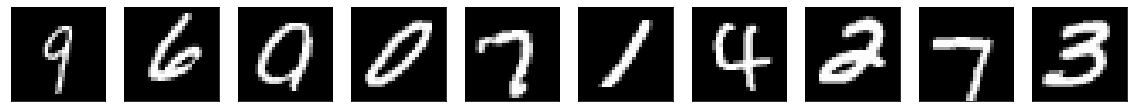

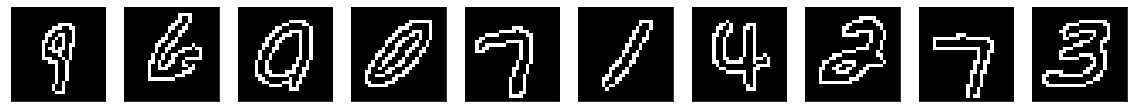

[tensor(9), tensor(6), tensor(9), tensor(0), tensor(7), tensor(1), tensor(4), tensor(2), tensor(7), tensor(3)]


In [20]:
# visualize erased images
plt.rcParams["figure.figsize"] = (20,3)
i =90#152
plottedimgs = [torch.movedim(orig_images_tensorized[i], 0 ,-1) for i in range(10*i,10*(i+1))]
plot(plottedimgs, num_rows=1)

plottedimgs = [torch.movedim(edge_images_tensorized[i], 0 ,-1) for i in range(10*i,10*(i+1))]
plot(plottedimgs, num_rows=1)

print([l.argmax() for l in orig_labels_tensorized[10*i:10*(i+1)]])

In [21]:
# save tensors 
filename = os.path.join(path_save, f'{dataset_type}_canny_edge.pt')
torch.save((orig_images_tensorized, edge_images_tensorized, orig_labels_tensorized), filename)
print(f'{filename} saved to disk')

../data/MNIST_recon/train_canny_edge.pt saved to disk


# Mnist for reconstruction (Erase)
original mnist training dataset: 60k
* recon-only (x*60k erased)
* recon-balance (x*30k intact + x*30k erased)
* recon-unbalanced (original 60k intact + x*60k erased)

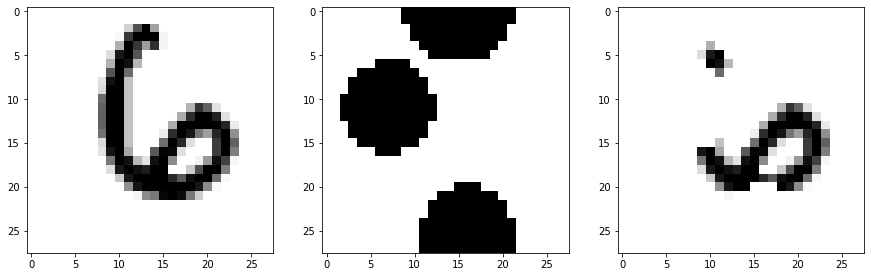

In [7]:
# partly erased stimuli demonstration
from scipy import ndimage
# np.random.seed(1)
fig = plt.figure(figsize=(15, 80))

im_set = datasets.MNIST('../data/',train=False, download=False)

# image
i = 88
im = np.array(im_set[i][0])
fig.add_subplot(1, 3, 1)
plt.imshow(im, cmap='gray_r')

## blots
nblots = 3
sigma = 3
blots = np.zeros(im.shape)
points = im.shape[0]*np.random.random((2, nblots))
blots[(points[0]).astype(np.int), (points[1]).astype(np.int)] = 1
blots = ndimage.gaussian_filter(blots, sigma=sigma)
blotmask = (blots > blots.mean()).astype(np.int)
fig.add_subplot(1, 3, 2)
plt.imshow(blotmask, cmap='gray_r')

# blotted
# bim = im.copy()
maskvalue = 0
np.putmask(im, blotmask, maskvalue)
fig.add_subplot(1, 3, 3)
plt.imshow(im, cmap='gray_r')
plt.show()

In [53]:
def get_randomly_erased_dataset(im_set, nblots=3):
    intact_images = []
    erased_images = []
    labels = []
    for img, label in im_set:
        img = np.array(img)
        intact_images.append(img)    
        erased = erase_image(img.copy(), nblots)
        erased_images.append(erased)
        labels.append(label)
        
    # convert to tensor and one-hot vector
    transform_tohot = T.Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
    intact_images_tensorized = torch.stack([T.ToTensor()(im) for im in intact_images])
    erased_images_tensorized = torch.stack([T.ToTensor()(im) for im in erased_images])
    labels_tensorized = torch.stack([transform_tohot(label) for label in labels])
    
    return intact_images_tensorized, erased_images_tensorized, labels_tensorized

def get_tensorized_dataset(im_set):
    images = []
    labels = []
    for img, label in im_set:
        img = np.array(img)
        images.append(img)    
        labels.append(label)
        
    # convert to tensor and one-hot vector
    transform_tohot = T.Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
    images_tensorized = torch.stack([T.ToTensor()(im) for im in images])
    labels_tensorized = torch.stack([transform_tohot(label) for label in labels])
    
    return images_tensorized, labels_tensorized

def erase_image(img, nblots=3, sigma=3, maskvalue=0):
    from scipy import ndimage
    # create blots
    blots = np.zeros(img.shape)
    points = img.shape[0]*np.random.random((2, nblots))
    blots[(points[0]).astype(np.int), (points[1]).astype(np.int)] = 1
    blots = ndimage.gaussian_filter(blots, sigma=sigma)
    blotmask = (blots > blots.mean()).astype(np.int)
    
    # put blotmask on original image 
    np.putmask(img, blotmask, maskvalue) # check how this works for 3D, RGB array
    
    return img

def plot(imgs, num_rows = 1, with_orig=False, row_title=None, **imshow_kwargs):
#     if not isinstance(imgs, list):
#         raise ValueError('input images should be list form')

    num_cols = int(len(imgs)/num_rows) + (len(imgs)%num_rows > 0)
    fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
#     import pdb; pdb.set_trace()
    for row_idx in range(num_rows):
        for col_idx, img in enumerate(imgs[row_idx*num_cols:(row_idx+1)*num_cols]):
            ax = axs[row_idx, col_idx]
            ax.imshow(np.asarray(img), cmap='gray_r', vmin=0, vmax=1,  **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

#     if with_orig:
#         axs[0, 0].set(title='Original image')
#         axs[0, 0].title.set_size(8)
    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])
    plt.show()
#     plt.tight_layout()

In [51]:
# load original mnist
path_save = '../data/MNIST_recon'
dataset_type = 'train'
if dataset_type == 'train':
    im_set = datasets.MNIST('../data/',train=True, download=False)
elif dataset_type == 'test':
    im_set = datasets.MNIST('../data/',train=False, download=False)

orig_images_tensorized, orig_labels_tensorized = get_tensorized_dataset(im_set)
print(orig_images_tensorized.size())
print(orig_labels_tensorized.size())

torch.Size([60000, 1, 28, 28])
torch.Size([60000, 10])


# create erased mnist

In [54]:
# convert original mnist to randomly erased mnist
random.seed(10)
increase_datasize_by=3

intact_images, erased_images, labels = [], [], []
for i in range(increase_datasize_by):
    intact, erased, lab = get_randomly_erased_dataset(im_set, nblots=2*i+1)
    intact_images.append(intact)
    erased_images.append(erased)
    labels.append(lab)
    
intact_images_tensorized = torch.cat(intact_images)
erased_images_tensorized = torch.cat(erased_images)
labels_tensorized = torch.cat(labels)

print(intact_images_tensorized.size())
print(erased_images_tensorized.size())
print(labels_tensorized.size())

torch.Size([180000, 1, 28, 28])
torch.Size([180000, 1, 28, 28])
torch.Size([180000, 10])


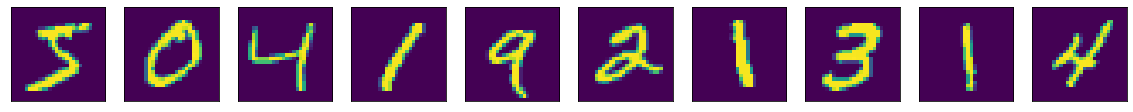

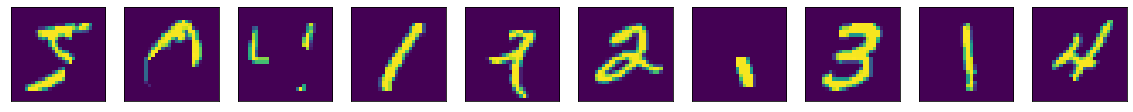

[tensor(5), tensor(0), tensor(4), tensor(1), tensor(9), tensor(2), tensor(1), tensor(3), tensor(1), tensor(4)]


In [55]:
# visualize erased images
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,3)
plottedimgs = [torch.movedim(intact_images_tensorized[i], 0 ,-1) for i in range(10)]
plot(plottedimgs, num_rows=1)
plottedimgs = [torch.movedim(erased_images_tensorized[i], 0 ,-1) for i in range(10)]
plot(plottedimgs, num_rows=1)
print([l.argmax() for l in labels_tensorized[:10]])

In [56]:
# save tensors recon-all
comment = '_nblot1to3'
filename = os.path.join(path_save, f'{dataset_type}_recon_only_x{increase_datasize_by}{comment}.pt')
torch.save((erased_images_tensorized, intact_images_tensorized, labels_tensorized), filename)
print(f'{filename} saved to disk')

../data/MNIST_recon/train_recon_only_x3_nblot1to3.pt saved to disk


## make the half & half dataset between intact and erased images

In [57]:
# get half indicies from each dataset
random.seed(10)
n_images = len(labels_tensorized)
all_indices = list(range(0, n_images))
erased_indices = random.sample(range(0, n_images), int(n_images/2))
erased_indices.sort()
intact_indices = list(set(all_indices)-set(erased_indices))
print(f'among {n_images} intact images, {int(n_images/2)} were replaced with erased version')
    
half_intact_images = intact_images_tensorized[intact_indices]
half_erased_images = erased_images_tensorized[erased_indices]
half_intact_labels = labels_tensorized[intact_indices]
half_erased_labels = labels_tensorized[erased_indices]
intact_images_for_half_erased = intact_images_tensorized[erased_indices]
half_intact_half_erased_images = torch.cat([half_intact_images, half_erased_images])
all_intact_images = torch.cat([half_intact_images, intact_images_for_half_erased])
half_intact_half_erased_labels  = torch.cat([half_intact_labels, half_erased_labels])

# shuffle the order
torch.manual_seed(10)
shuffled_indices = torch.randperm(half_intact_half_erased_images.shape[0])
half_intact_half_erased_images = half_intact_half_erased_images[shuffled_indices]
all_intact_images = all_intact_images[shuffled_indices]
half_intact_half_erased_labels = half_intact_half_erased_labels[shuffled_indices]

print(half_intact_half_erased_images.size())
print(all_intact_images.size())
print(half_intact_half_erased_labels.size())

among 180000 intact images, 90000 were replaced with erased version
torch.Size([180000, 1, 28, 28])
torch.Size([180000, 1, 28, 28])
torch.Size([180000, 10])


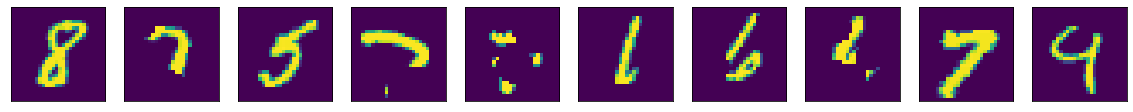

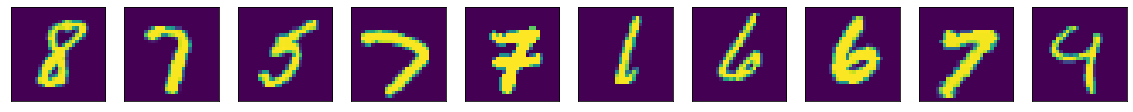

[tensor(8), tensor(7), tensor(5), tensor(7), tensor(7), tensor(1), tensor(6), tensor(6), tensor(7), tensor(9)]


In [58]:
# visualize erased images
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,3)
plottedimgs = [torch.movedim(half_intact_half_erased_images[i], 0 ,-1) for i in range(10)]
plot(plottedimgs, num_rows=1)
plottedimgs = [torch.movedim(all_intact_images[i], 0 ,-1) for i in range(10)]
plot(plottedimgs, num_rows=1)
print([l.argmax() for l in half_intact_half_erased_labels[:10]])

In [59]:
# tensor save recon-half
comment = '_nblot1to3'
filename = os.path.join(path_save, f'{dataset_type}_recon_half_x{increase_datasize_by}{comment}.pt')
torch.save((half_intact_half_erased_images, all_intact_images, half_intact_half_erased_labels), filename)
print(f'{filename} saved to disk')

../data/MNIST_recon/train_recon_half_x3_nblot1to3.pt saved to disk


# concat erased images to original mnist 

In [60]:
#concate intact + erased
combine_intact_erased_images = torch.cat([orig_images_tensorized, erased_images_tensorized]) # torch.Size([120000, 28, 28])
combine_intact_images = torch.cat([orig_images_tensorized, intact_images_tensorized])
combine_labels_tensorized = torch.cat([orig_labels_tensorized, labels_tensorized]) #

# shuffle the order
torch.manual_seed(10)
shuffled_indices = torch.randperm(combine_intact_erased_images.shape[0])
combine_intact_erased_images = combine_intact_erased_images[shuffled_indices]
combine_intact_images = combine_intact_images[shuffled_indices]
combine_labels_tensorized = combine_labels_tensorized[shuffled_indices]

print(combine_intact_erased_images .size())
print(combine_intact_images.size())
print(combine_labels_tensorized.size())

torch.Size([240000, 1, 28, 28])
torch.Size([240000, 1, 28, 28])
torch.Size([240000, 10])


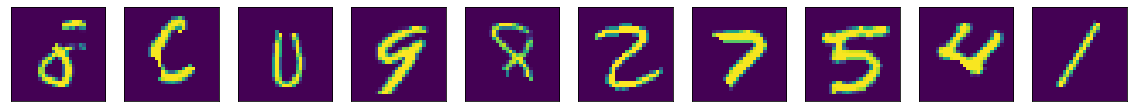

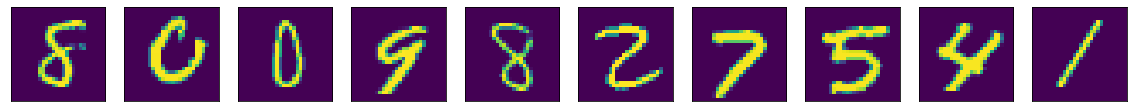

[tensor(8), tensor(0), tensor(0), tensor(9), tensor(8), tensor(2), tensor(7), tensor(5), tensor(4), tensor(1)]


In [61]:
# visualize erased images
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,3)
plottedimgs = [torch.movedim(combine_intact_erased_images[i], 0 ,-1) for i in range(10)]
plot(plottedimgs, num_rows=1)
plottedimgs = [torch.movedim(combine_intact_images[i], 0 ,-1) for i in range(10)]
plot(plottedimgs, num_rows=1)
print([l.argmax() for l in combine_labels_tensorized[:10]])

In [62]:
# tensor save recon-half
comment = '_nblot1to3'
filename = os.path.join(path_save, f'{dataset_type}_recon_combine_x{increase_datasize_by}{comment}.pt')
torch.save((combine_intact_erased_images, combine_intact_images, combine_labels_tensorized), filename)
print(f'{filename} saved to disk')

../data/MNIST_recon/train_recon_combine_x3_nblot1to3.pt saved to disk
